# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# Import Librariesimport os
import re

from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, when, isnull, collect_list
from pyspark.sql.types import IntegerType, BooleanType, FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.storagelevel import StorageLevel
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import importlib
%matplotlib inline

In [2]:
# Create a spark session
spark = SparkSession.builder.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Read in mini sparkify dataset in the local environment
event_data = "./mini_sparkify_event_data.json"
df = spark.read.json(event_data)

# Let's see the preview of the data
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [4]:
print((df.count(), len(df.columns)))

(286500, 18)


In [5]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [6]:
# Let's see what all pages have been visited by users
df.select('page').distinct().show(50)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [7]:
# Select relevant columns
df_clean = df.select('artist','auth','firstName','gender','lastName','length','level','location','page','song','ts','userId')

In [8]:
# Combine all auths in one column so that we can search for Cancelled i.e. our churn definition
df_churn = df_clean.groupby('userId').agg(collect_list('auth').alias("auths"))

In [9]:
df_churn.show(1)

+------+--------------------+
|userId|               auths|
+------+--------------------+
|100010|[Logged In, Logge...|
+------+--------------------+
only showing top 1 row



In [10]:
# Create a custom UDF for creating the churned column
udf_churned = udf(lambda x: 'Cancelled' in x)

In [11]:
# Create the churned column and drop the auths column
df_churn = df_churn.withColumn("Churned", udf_churned(df_churn.auths))
df_churn = df_churn.drop('auths')

In [12]:
# Join the churn df with the clean df on the basis of user ID
df_label = df_churn.join(df_clean,'userId')

In [13]:
# Show the first record of df_label
df_label.show(1)

+------+-------+--------------------+---------+---------+------+---------+---------+-----+--------------------+--------+--------------------+-------------+
|userId|Churned|              artist|     auth|firstName|gender| lastName|   length|level|            location|    page|                song|           ts|
+------+-------+--------------------+---------+---------+------+---------+---------+-----+--------------------+--------+--------------------+-------------+
|100010|  false|Sleeping With Sirens|Logged In| Darianna|     F|Carpenter|202.97098| free|Bridgeport-Stamfo...|NextSong|Captain Tyin Knot...|1539003534000|
+------+-------+--------------------+---------+---------+------+---------+---------+-----+--------------------+--------+--------------------+-------------+
only showing top 1 row



In [14]:
# Let's see the distribution of churned column
df_label.select(["userId","Churned"]).distinct().groupBy("Churned").count().collect()

[Row(Churned='false', count=174), Row(Churned='true', count=52)]

In [15]:
# Let's see how many null values are there in each column
df_label.select([count(when(isnull(column), column)).alias(column) for column in df_label.columns]).show()

+------+-------+------+----+---------+------+--------+------+-----+--------+----+-----+---+
|userId|Churned|artist|auth|firstName|gender|lastName|length|level|location|page| song| ts|
+------+-------+------+----+---------+------+--------+------+-----+--------+----+-----+---+
|     0|      0| 58392|   0|     8346|  8346|    8346| 58392|    0|    8346|   0|58392|  0|
+------+-------+------+----+---------+------+--------+------+-----+--------+----+-----+---+



In [16]:
# Persist the dataframe both in memory and on disk
df_label.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[userId: string, Churned: string, artist: string, auth: string, firstName: string, gender: string, lastName: string, length: double, level: string, location: string, page: string, song: string, ts: bigint]

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [17]:
# Calculate Thumbs Up: Filter ‘Thumbs Up’ page visits groups then group that data by users,
# aggregates the counts of the ‘Thumbs Up’ page per user, give alias name to the column and finally order the results by userId.
thumbs_up = df_label.where(df_label.page=='Thumbs Up').groupby("userId").agg(count(col('page')).alias('ThumbsUp')).orderBy('userId')

In [18]:
# Calculate Thumbs Down: Filter ‘Thumbs Down’ page visits groups then group that data by users,
# aggregates the counts of the ‘Thumbs Down’ page per user, give alias name to the column and finally order the results by userId.
thumbs_down = df_label.where(df_label.page=='Thumbs Down').groupby("userId").agg(count(col('page')).alias('ThumbsDown')).orderBy('userId')

In [19]:
# Join both thumbs up and thumbs join using userID
thumbs_up_and_down = thumbs_up.join(thumbs_down,'userId')

In [20]:
# Calculate Songs Played by a user
songs_played = df_label.where(col('song')!='null').groupby("userId").agg(count(col('song')).alias('SongsPlayed')).orderBy('userId')

In [21]:
# Join songs played and all thumbs data to the df features
df_features = df_churn.join(songs_played,'userId')
df_features = df_features.join(thumbs_up_and_down,'userId')

In [22]:
# Calculate number of days user has been using the service
days = df_label.groupby('userId').agg(((max(col('ts')) - min(col('ts')))/86400000).alias("Days"))
df_features = df_features.join(days, "userId")

In [23]:
# Check null count in key features. After running this cell it's clear that it's all zero null in these features.
df_features.select([count(when(isnull(column), column)).alias(column) for column in ["userId", "SongsPlayed", "ThumbsUp", "ThumbsDown", "Days"]]).show()

+------+-----------+--------+----------+----+
|userId|SongsPlayed|ThumbsUp|ThumbsDown|Days|
+------+-----------+--------+----------+----+
|     0|          0|       0|         0|   0|
+------+-----------+--------+----------+----+



In [24]:
# This is to avoid the problem which can occur in full data set i.e. 
# a Spark UDF will return a column of NULLs if the input data type doesn’t match the output data type.
udf_thumbs_up_per_song = udf(lambda thumbsUp, songsPlayed: float(thumbsUp)/float(songsPlayed), FloatType())
udf_thumbs_down_per_song = udf(lambda thumbsDown, songsPlayed: float(thumbsDown)/float(songsPlayed), FloatType())
udf_songs_played_per_hour = udf(lambda songsPlayed, numberOfDays: float(songsPlayed)/float((numberOfDays*24)), FloatType())

In [25]:
# Add the Thumbs UpPerSong using UDF
df_features = df_features.withColumn("ThumbsUpPerSong", udf_thumbs_up_per_song(df_features.ThumbsUp, df_features.SongsPlayed))

In [26]:
# Add the Thumbs DownPerSong using UDF
df_features = df_features.withColumn("ThumbsDownPerSong", udf_thumbs_down_per_song(df_features.ThumbsDown, df_features.SongsPlayed))

In [27]:
# Add the SongsPerHour feature using UDF
df_features = df_features.withColumn("SongsPerHour", udf_songs_played_per_hour(df_features.SongsPlayed, df_features.Days))

In [28]:
# Let's see what's the average of SongsPerHour for both churned as well as non churned users
# It seems that user who got churned have played more songs compared to users who didn't get churned. 
# Do they get bored?? Or they didn't like the service after experimenting a lot?
df_features.select("SongsPerHour", "Churned").groupby("Churned").agg(avg(col('SongsPerHour'))).show()

+-------+------------------+
|Churned| avg(SongsPerHour)|
+-------+------------------+
|  false|1.3289544926175187|
|   true| 2.415751484163264|
+-------+------------------+



In [29]:
df_features.select([count(when(isnull(c), c)).alias(c) for c in ["SongsPlayed", "ThumbsUpPerSong", "ThumbsDownPerSong", "Days", "SongsPerHour"]]).show()

+-----------+---------------+-----------------+----+------------+
|SongsPlayed|ThumbsUpPerSong|ThumbsDownPerSong|Days|SongsPerHour|
+-----------+---------------+-----------------+----+------------+
|          0|              0|                0|   0|           0|
+-----------+---------------+-----------------+----+------------+



In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
%matplotlib inline

In [31]:
df_features_pandas = df_features.toPandas()

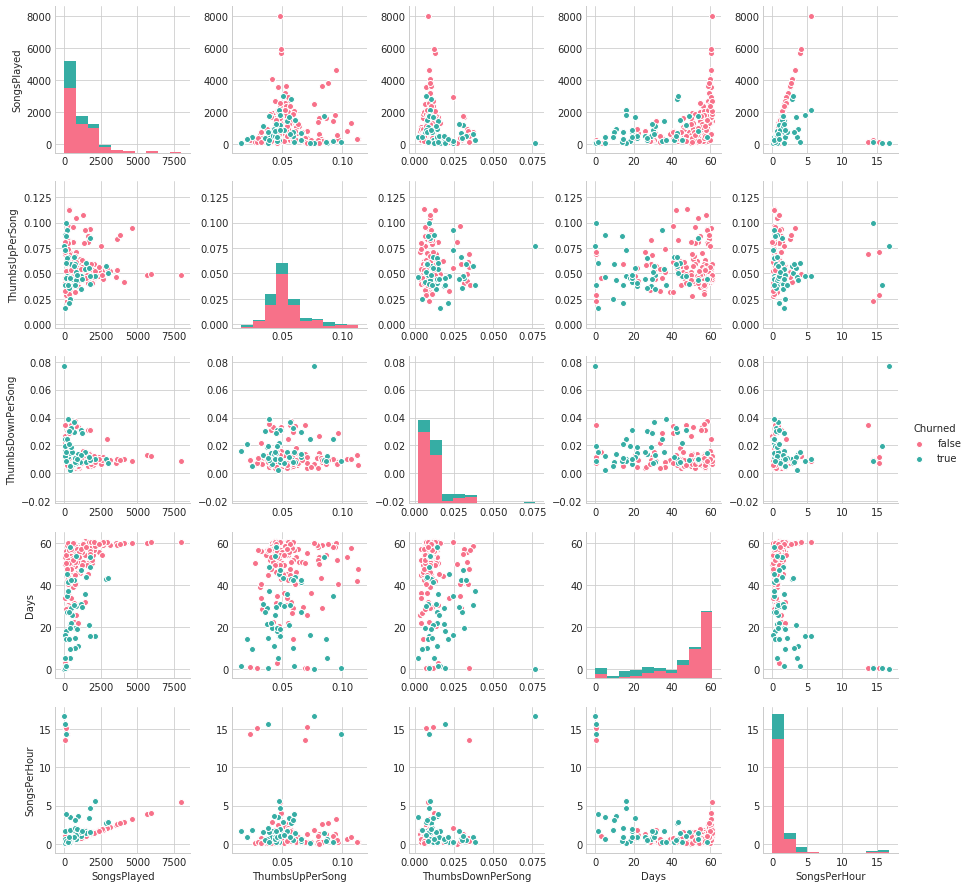

In [32]:
sns.pairplot(df_features_pandas[["SongsPlayed", "ThumbsUpPerSong", "ThumbsDownPerSong", "Days", "SongsPerHour","Churned"]],hue="Churned", palette="husl")

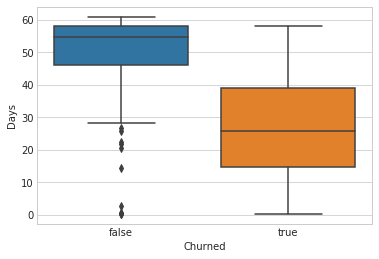

In [33]:
#It is intersting that if someone is using system for 60 days or more it has low chances of Churn
sns.boxplot(x="Churned", y="Days", data=df_features_pandas)

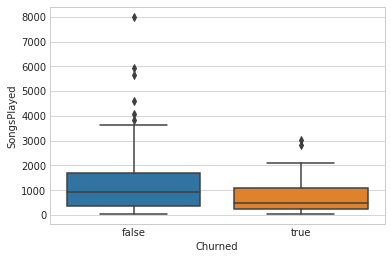

In [34]:
#Someone who has more songs has relatively lower chances of churn
sns.boxplot(x="Churned", y="SongsPlayed", data=df_features_pandas)

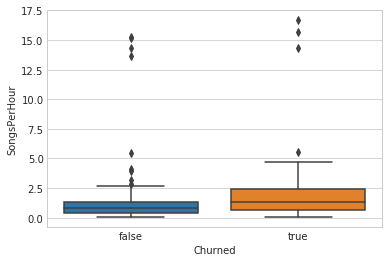

In [35]:
#It is surprising that someone playing more songs per hour has relatively higher chances of Churn. He gets bored after listening more?
sns.boxplot(x="Churned", y="SongsPerHour", data=df_features_pandas)

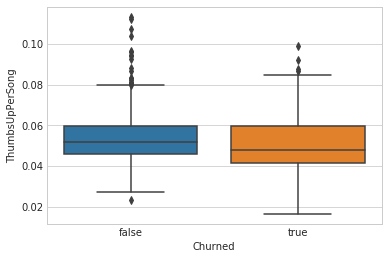

In [36]:
sns.boxplot(x="Churned", y="ThumbsUpPerSong", data=df_features_pandas)

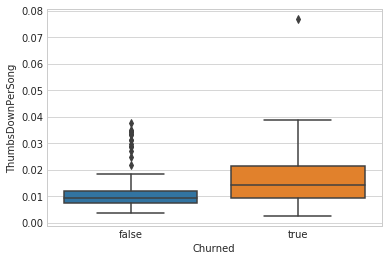

In [37]:
#ThumbsDownPerSong has more sensitivity to chrun compared to ThumbsUpPerSong
sns.boxplot(x="Churned", y="ThumbsDownPerSong", data=df_features_pandas)

In [38]:
assembler = VectorAssembler(inputCols=["SongsPlayed", "ThumbsUpPerSong", "ThumbsDownPerSong", "Days", "SongsPerHour"], outputCol="FeatureVector")
df_features = assembler.transform(df_features)

In [39]:
scaler = StandardScaler(inputCol="FeatureVector", outputCol="ScaledFeatures", withStd=True)
scaler_tranformer = scaler.fit(df_features)
df_features = scaler_tranformer.transform(df_features)

In [40]:
df_features.show()

+------+-------+-----------+--------+----------+------------------+---------------+-----------------+------------+--------------------+--------------------+
|userId|Churned|SongsPlayed|ThumbsUp|ThumbsDown|              Days|ThumbsUpPerSong|ThumbsDownPerSong|SongsPerHour|       FeatureVector|      ScaledFeatures|
+------+-------+-----------+--------+----------+------------------+---------------+-----------------+------------+--------------------+--------------------+
|100010|  false|        275|      17|         5| 44.21780092592593|    0.061818182|      0.018181818|  0.25913393|[275.0,0.06181818...|[0.24639992057147...|
|200002|  false|        387|      21|         6|45.496805555555554|    0.054263566|      0.015503876|  0.35442048|[387.0,0.05426356...|[0.34675188822240...|
|   124|  false|       4079|     171|        41|59.996944444444445|     0.04192204|      0.010051483|   2.8327832|[4079.0,0.0419220...|[3.65478282185840...|
|    51|   true|       2111|     100|        21|15.7793981

In [41]:
# UDF for convert label or targeting variable to integer
convertToInt = udf(lambda x: 1 if x=="true" else 0, IntegerType())

In [42]:
# Now copy the churned column to label column post converting to integer
df_features = df_features.withColumn('label', convertToInt(df_features.Churned))

In [43]:
df_features.show()

+------+-------+-----------+--------+----------+------------------+---------------+-----------------+------------+--------------------+--------------------+-----+
|userId|Churned|SongsPlayed|ThumbsUp|ThumbsDown|              Days|ThumbsUpPerSong|ThumbsDownPerSong|SongsPerHour|       FeatureVector|      ScaledFeatures|label|
+------+-------+-----------+--------+----------+------------------+---------------+-----------------+------------+--------------------+--------------------+-----+
|100010|  false|        275|      17|         5| 44.21780092592593|    0.061818182|      0.018181818|  0.25913393|[275.0,0.06181818...|[0.24639992057147...|    0|
|200002|  false|        387|      21|         6|45.496805555555554|    0.054263566|      0.015503876|  0.35442048|[387.0,0.05426356...|[0.34675188822240...|    0|
|   124|  false|       4079|     171|        41|59.996944444444445|     0.04192204|      0.010051483|   2.8327832|[4079.0,0.0419220...|[3.65478282185840...|    0|
|    51|   true|      

In [44]:
# Split the data into train, test and validation
train_ratio = 0.8
test_ratio = 0.2
validation_ratio = 0.2
train, test = df_features.randomSplit([train_ratio, test_ratio], seed=9999)
train, validation = train.randomSplit([(1 - validation_ratio), validation_ratio], seed=9999)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [45]:
# This is for internal so that we can play with multiple models
relevant_module_class = 'pyspark.ml.classification'
relevant_model_class = 'RandomForestClassifier' # LogisticRegression
model_params = {'featuresCol': 'FeatureVector', 'labelCol': 'label', 'maxIter': 10} if relevant_model_class == 'LogisticRegression' else {'featuresCol': 'FeatureVector', 'labelCol': 'label', 'numTrees': 10}
relevant_module = importlib.import_module(relevant_module_class)
relevant_model = getattr(relevant_module,relevant_model_class)
model = relevant_model(**model_params)

In [53]:
import numpy as np
import pandas as pd

def evaluate_performance(trained_model,train,validation,test,evaluator):    
    # Test the performance via evaluator on training data
    predictions = trained_model.transform(train)
    print('Train: Area Under ROC', evaluator.setMetricName("areaUnderROC").evaluate(predictions))
    print('Train: Area Under PR', evaluator.setMetricName("areaUnderPR").evaluate(predictions))
    
    # Test the performance via evaluator on validation data
    predictions = trained_model.transform(validation)
    print('Validation: Area Under ROC', evaluator.setMetricName("areaUnderROC").evaluate(predictions))
    print('Validation: Area Under PR', evaluator.setMetricName("areaUnderPR").evaluate(predictions))
    
    # Test the performance via evaluator on test data
    predictions = trained_model.transform(test)
    print('Test: Area Under ROC', evaluator.setMetricName("areaUnderROC").evaluate(predictions))
    print('Test: Area Under PR', evaluator.setMetricName("areaUnderPR").evaluate(predictions))

def get_classifier_metrics(trained_model, train, test, validation):
    '''
    
    '''
    def get_metrics(trained_model, data):
        '''
        
        '''
        label_and_prediction = trained_model.transform(data).select('label', 'prediction')
        true_positives = label_and_prediction.filter((label_and_prediction.prediction==1)& (label_and_prediction.label == label_and_prediction.prediction) ).count()
        true_negatives = label_and_prediction.filter((label_and_prediction.prediction==0)& (label_and_prediction.label == label_and_prediction.prediction) ).count()
        false_positives = label_and_prediction.filter((label_and_prediction.prediction==1)& (label_and_prediction.label != label_and_prediction.prediction) ).count()
        false_negatives = label_and_prediction.filter((label_and_prediction.prediction==0)& (label_and_prediction.label != label_and_prediction.prediction) ).count()
        accuracy = label_and_prediction.filter(label_and_prediction.label == label_and_prediction.prediction).count()/label_and_prediction.count()
        precision = true_positives/(true_positives+false_positives)
        recall = true_positives/(true_positives+false_negatives)
        f1score = 2 * precision * recall / (precision + recall)
        return accuracy, precision, recall, f1score
    train_metrics = get_metrics(trained_model, train)
    validation_metrics = get_metrics(trained_model,validation)
    test_metrics = get_metrics(trained_model, test)
    
    labels =['Train', 'Validation','Test']
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F-Score']
    metrics_data =np.array((train_metrics, validation_metrics, test_metrics))
    return pd.DataFrame(data=metrics_data.T, columns=labels, index=metrics_names)

In [47]:
from pyspark.ml.classification import RandomForestClassifier
evaluator = BinaryClassificationEvaluator()
model = RandomForestClassifier(featuresCol = 'FeatureVector', labelCol = 'label', numTrees=100)

In [48]:
trained_model = model.fit(train)

In [49]:
evaluate_performance(trained_model,train,validation,test,evaluator)

Train: Area Under ROC 0.9982638888888888
Train: Area Under PR 0.9931084034611481
Validation: Area Under ROC 0.9047619047619048
Validation: Area Under PR 0.8500000000000001
Test: Area Under ROC 0.8863636363636364
Test: Area Under PR 0.840636233892813


In [54]:
get_classifier_metrics(trained_model,train,validation,test)

,Train,Validation,Test
Accuracy,0.981013,0.852941,0.800000
Precision,0.967742,0.888889,0.666667
Recall,0.937500,0.666667,0.666667
F-Score,0.952381,0.761905,0.666667


In [55]:
trained_model.coefficients if relevant_model_class == 'LogisticRegression' else trained_model.featureImportances

SparseVector(5, {0: 0.2149, 1: 0.062, 2: 0.1681, 3: 0.4368, 4: 0.1183})

In [56]:
# Run through a cross validator
param_grid = ParamGridBuilder().addGrid(model.regParam, [0.1, 0.01]).build() if type(model).__name__ == 'LogisticRegression' else ParamGridBuilder().addGrid(model.numTrees, [25, 50, 75]).build()

crossval = CrossValidator(estimator=model,
                          estimatorParamMaps=param_grid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)
trained_model = crossval.fit(train)

In [57]:
evaluate_performance(trained_model,train,validation,test,evaluator)

Train: Area Under ROC 0.9985119047619048
Train: Area Under PR 0.9942052322788821
Validation: Area Under ROC 0.9047619047619048
Validation: Area Under PR 0.8500000000000001
Test: Area Under ROC 0.8579545454545455
Test: Area Under PR 0.826208854004175


In [58]:
get_classifier_metrics(trained_model,train,validation,test)

,Train,Validation,Test
Accuracy,0.981013,0.823529,0.800000
Precision,0.967742,0.875000,0.666667
Recall,0.937500,0.583333,0.666667
F-Score,0.952381,0.700000,0.666667


In [ ]:
# EXPERIMENTED BUT DIDN'T USE
#training_summary = trained_model.summary

# Get the receiver-operating characteristic as a dataframe and areaUnderROC.
# training_summary.roc.show()
#print("areaUnderROC: " + str(training_summary.areaUnderROC))

# objectiveHistory = training_summary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

#f_measure = training_summary.fMeasureByThreshold
#max_f_measure = f_measure.groupBy().max('F-Measure').select('max(F-Measure)').head()
#best_threshold = f_measure.where(f_measure['F-Measure'] == max_f_measure['max(F-Measure)']) \
#    .select('threshold').head()['threshold']

#f_measure.show()
#print(best_threshold)
#print(max_f_measure)

# model.setThreshold(best_threshold)

#pr = training_summary.pr
#pr.show()

#predictions.show()
#print(predictions.filter(predictions.label == predictions.prediction).count())
#print(predictions.count())

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

# Based on the coefficients, the features that contribute the most are:

Average number of thumbs down per song played, number of songs played and days on system.